## Rossmann Store Sales Predictive Model


We will be using different predictive models for Rossmann Store Sales prediction. The models include regression trees, linear regression(Lasso), AdaBoostRegressor, Seasonal ARIMA and XGBRegressor. 


#### Prepare data for prediction

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# specify dtype of column Stateholiday

types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("C:/Users/fanko/Dropbox/2018 Fall/MSBA 6420 - Predictive Analytics/Homework/HW4/HW4/train.csv", \
                    parse_dates=[2], dtype=types)
store = pd.read_csv("C:/Users/fanko/Dropbox/2018 Fall/MSBA 6420 - Predictive Analytics/Homework/HW4/HW4/store.csv")
test = pd.read_csv("C:/Users/fanko/Dropbox/2018 Fall/MSBA 6420 - Predictive Analytics/Homework/HW4/HW4/test.csv", \
                  parse_dates=[3], dtype=types)

In [3]:
# train data structure
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [5]:
# briefly look at train data
print (train.head(5))
print (test.head(5))

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17   1.0      1            0              0
3   4      8          4 2015-09-17   1.0      1            0              0
4   5      9          4 2015-09-17   

In [6]:
# check max & min of train data

pd.set_option('float_format', '{:f}'.format)
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000


In [7]:
# check store data
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,nan,nan,NaN
1,2,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9.000000,2009.000000,0,nan,nan,NaN
4,5,a,a,29910.000000,4.000000,2015.000000,0,nan,nan,NaN


#### Data checkup 

In [8]:
# check if there is any sales when store is closed
store_closed_no_sales = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("There is no sales when store is closed: " + str(store_closed_no_sales.empty))

There is no sales when store is closed: True


#### Training & testing dataset

In [9]:
# merge store and train data

merge = pd.merge(train, store, on='Store', how='left')
test_merge = pd.merge(test, store, on='Store', how='left')

print (merge.head())
print (test_merge.head())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a          1270.000000   
1              1         a          a           570.000000   
2              1         a          a         14130.000000   
3              1         c          c           620.000000   
4              1         a          a         29910.000000   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                   9.000000               2008.000000       0   
1                  11.0000

In [10]:
# remove NaNs

merge_1 = merge.fillna(0)
test_1 = test_merge.fillna(0)

merge_1.info()
test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [11]:
# one-hot encoding

merge_2_1 =pd.concat([merge_1, pd.get_dummies(merge['StateHoliday'], prefix='StateHoliday')], axis=1)
merge_2_2= pd.concat([merge_2_1, pd.get_dummies(merge['StoreType'], prefix='StoreType')], axis=1)
merge_3= pd.concat([merge_2_2, pd.get_dummies(merge['Assortment'], prefix='Assortment')], axis=1)
merge_3.info()

test_2_1 =pd.concat([test_1, pd.get_dummies(test_merge['StateHoliday'], prefix='StateHoliday')], axis=1)
test_2_2= pd.concat([test_2_1, pd.get_dummies(test_merge['StoreType'], prefix='StoreType')], axis=1)
test_3= pd.concat([test_2_2, pd.get_dummies(test_merge['Assortment'], prefix='Assortment')], axis=1)
test_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 29 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

Note - test data only contains State Holiday 0 & a rather than all four types of holidays. This should be taken into account while training the predictive models. 

In [12]:
# specify date, month, year and week

merge_3['Year'] = merge_3.Date.dt.year
merge_3['Month'] = merge_3.Date.dt.month
merge_3['Day'] = merge_3.Date.dt.day
merge_3['Week'] = merge_3.Date.dt.week

merge_3.info()

test_3['Year'] = test_3.Date.dt.year
test_3['Month'] = test_3.Date.dt.month
test_3['Day'] = test_3.Date.dt.day
test_3['Week'] = test_3.Date.dt.week


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 33 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [13]:
# get all columns names

col_names = list(merge_3.columns.values)
print (col_names)

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Year', 'Month', 'Day', 'Week']


In [14]:
test_col_names = list(test_3.columns.values)
print (test_col_names)

['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'StateHoliday_0', 'StateHoliday_a', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Year', 'Month', 'Day', 'Week']


In [15]:
# define feature and target columns

feature_name = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', \
                'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', \
                'StateHoliday_0', 'StateHoliday_a', \
                'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', \
                'Assortment_a', 'Assortment_b', 'Assortment_c', 
                'Year', 'Month', 'Day', 'Week']
target = ['Sales']
modelList = []

In [16]:
#split data into training & testing for all models
from sklearn.cross_validation import train_test_split

data_features = merge_3[feature_name]  # X Variables
data_target = merge_3['Sales']  # Y Prediction

#split the data into testing, and training sets.
#start testing / training ratio 2:8 & random_state = 42 for reproducible result
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(merge_3[feature_name], merge_3['Sales'], test_size=0.2, random_state=42)

C:\Users\fanko\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
# define feature and target columns

test_feature_name = ['Id','Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', \
                'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', \
                'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', \
                'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', \
                'Assortment_a', 'Assortment_b', 'Assortment_c', 
                'Year', 'Month', 'Day', 'Week']

In [18]:
print (data_x_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813767 entries, 417683 to 121958
Data columns (total 23 columns):
Store                        813767 non-null int64
DayOfWeek                    813767 non-null int64
Customers                    813767 non-null int64
Open                         813767 non-null int64
Promo                        813767 non-null int64
SchoolHoliday                813767 non-null int64
CompetitionDistance          813767 non-null float64
CompetitionOpenSinceMonth    813767 non-null float64
CompetitionOpenSinceYear     813767 non-null float64
Promo2                       813767 non-null int64
StateHoliday_0               813767 non-null uint8
StateHoliday_a               813767 non-null uint8
StoreType_a                  813767 non-null uint8
StoreType_b                  813767 non-null uint8
StoreType_c                  813767 non-null uint8
StoreType_d                  813767 non-null uint8
Assortment_a                 813767 non-null uint8
Assortment_

In [19]:
data_col_name = list(data_x_train)

In [20]:
#normalize the data

from sklearn import preprocessing

customer_normalizer = preprocessing.Normalizer().fit(data_x_train.iloc[:,2:3])
competition_normalizer = preprocessing.Normalizer().fit(data_x_train.iloc[:,6:9])

nor_x_train_num_cust = customer_normalizer.transform(data_x_train.iloc[:,2:3]) 
nor_x_test_num_cust = customer_normalizer.transform(data_x_test.iloc[:,2:3]) 

nor_x_train_num_comp = competition_normalizer.transform(data_x_train.iloc[:,6:9]) 
nor_x_test_num_comp = competition_normalizer.transform(data_x_test.iloc[:,6:9]) 

nor_x_train = np.concatenate((data_x_train.iloc[:,0:2].values,nor_x_train_num_cust,data_x_train.iloc[:,3:6].values, \
                             nor_x_train_num_comp, data_x_train.iloc[:,9:25].values,),axis =1)
nor_x_test = np.concatenate((data_x_test.iloc[:,0:2].values,nor_x_test_num_cust,data_x_test.iloc[:,3:6].values, \
                             nor_x_test_num_comp, data_x_test.iloc[:,9:25].values,),axis =1)

print (nor_x_train[:1])
print (nor_x_test[:1])

[[3.44000000e+02 7.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.47546470e-01 1.96728626e-03
  9.89053168e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 2.01400000e+03
  6.00000000e+00 2.20000000e+01 2.50000000e+01]]
[[6.16000000e+02 7.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.34026737e-01 2.19480720e-03
  5.51719661e-01 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 2.01500000e+03
  5.00000000e+00 2.40000000e+01 2.10000000e+01]]


In [21]:
data_x_train_col_name = list(data_x_train)
print (data_x_train_col_name)

['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'StateHoliday_0', 'StateHoliday_a', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Year', 'Month', 'Day', 'Week']


In [22]:
#covert normalized np.array into dataframe

data_x_train_col_name = list(data_x_train)

nor_x_train = pd.DataFrame(data=nor_x_train, columns = data_x_train_col_name)
nor_x_test =  pd.DataFrame(data=nor_x_test, columns = data_x_train_col_name)

print (nor_x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 23 columns):
Store                        813767 non-null float64
DayOfWeek                    813767 non-null float64
Customers                    813767 non-null float64
Open                         813767 non-null float64
Promo                        813767 non-null float64
SchoolHoliday                813767 non-null float64
CompetitionDistance          813767 non-null float64
CompetitionOpenSinceMonth    813767 non-null float64
CompetitionOpenSinceYear     813767 non-null float64
Promo2                       813767 non-null float64
StateHoliday_0               813767 non-null float64
StateHoliday_a               813767 non-null float64
StoreType_a                  813767 non-null float64
StoreType_b                  813767 non-null float64
StoreType_c                  813767 non-null float64
StoreType_d                  813767 non-null float64
Assortment_a                 813767 non-n

In [23]:
#evaluation is based on the Root Mean Square Percentage Error (RMSPE). Define error calculating function. 

def rmspe(model_name, y, y_hat):
    outcome = np.sqrt(np.mean(((y - y_hat) / y) ** 2))
    return ("RMSPE for " + str(model_name) + " is " + str(outcome))

In [24]:
#make scorer for the model

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) 

In [25]:
#plot of importance features 
def feature_importance_plot(model):
    k = list(zip(feature_name, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(feature_name)), vals, align='center')
    plt.yticks(np.arange(len(feature_name)), labels)

### Predictive models

#### Regression trees

'RMSPE for Decision Tree is 0.27196669110954486'

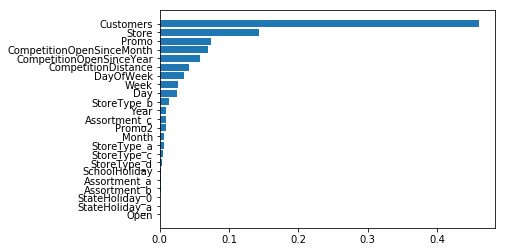

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

decision_tree = DecisionTreeRegressor()
decision_tree.fit(nor_x_train, data_y_train)
feature_importance_plot(decision_tree)
y_hat = decision_tree.predict(nor_x_test)
rmspe("Decision Tree",data_y_test, y_hat)

In [27]:
print (type(y_hat))
print (y_hat)
print (data_y_test.head())

<class 'numpy.ndarray'>
[    0.  5632.  5915. ...  3115.     0. 15968.]
76435         0
923026     5548
731180     7467
790350     3360
252134    11414
Name: Sales, dtype: int64


#### Linear regression(Lasso)

In [28]:
#lasso regression 

from sklearn.linear_model import Lasso

#lasso regression
lasso = Lasso(alpha = 0.4)

#fit the regressor 
lasso.fit(nor_x_train, data_y_train)
lasso_pred = lasso.predict(nor_x_test)
lasso.score(nor_x_test, data_y_test)

#lasso regression for feature selection
lasso_coef = lasso.fit(data_features, data_target).coef_

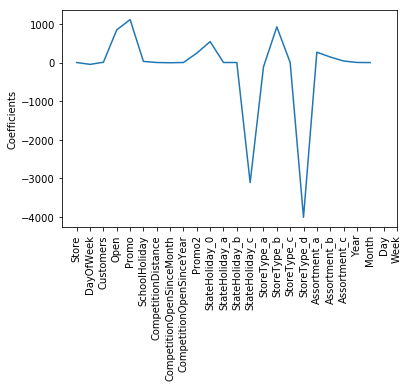

In [29]:
#plot the coefficient

plt.plot(range(len(feature_name)), lasso_coef)
#range(len(feature_name)) = 24
plt.xticks(np.arange(25), (['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', \
                            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', \
                            'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',\
                            'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', \
                            'Assortment_a', 'Assortment_b', 'Assortment_c', 'Year', 'Month', 'Day', 'Week']),rotation = 90)
plt.ylabel("Coefficients")
plt.show()

Based on above charts, we can see 'Open','Promo','StateHoliday_0','StateHoliday_c','StoreType_c','StoreType_d','Assortment_c' have most influence on predictive models. 

In [30]:
#use only selected features
lasso_feature = ['Open','Promo','StateHoliday_0','StateHoliday_c','StoreType_c','StoreType_d','Assortment_c']
target = ['Sales']

#split new data into training & testing for all models

lasso_features = merge_3[lasso_feature]  # X Variables
lasso_target = merge_3[target]  # Y Prediction

#split the data into testing, and training sets same as previous
lasso_x_train, lasso_x_test, lasso_y_train, lasso_y_test = train_test_split(lasso_features, lasso_target, \
                                                                            test_size=0.3, random_state=42)

print (lasso_y_test.head())


        Sales
76435       0
923026   5548
731180   7467
790350   3360
252134  11414


In [31]:
#build model

lr = linear_model.LinearRegression()
lr.fit(lasso_x_train, lasso_y_train)

#predict on the lasso test data

lasso_y_pred = lr.predict(lasso_x_test)

lasso_y_pred_ =  lasso_y_pred.ravel()
print (lasso_y_test['Sales'].head())
print (lasso_y_pred_)
print (type(lasso_y_pred_))

rmspe("Lasso",lasso_y_test['Sales'],lasso_y_pred_)

76435         0
923026     5548
731180     7467
790350     3360
252134    11414
Name: Sales, dtype: int64
[ 433.38974807 8035.47014863 5808.49864544 ... 6419.60301607  433.38974807
 6250.83825718]
<class 'numpy.ndarray'>


'RMSPE for Lasso is inf'

#### AdaBoostRegressor

C:\Users\fanko\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


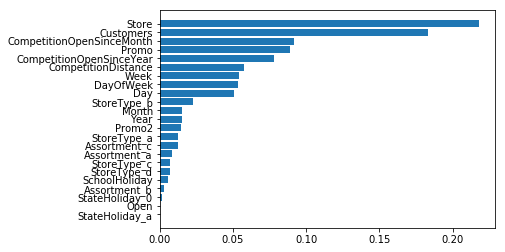

In [32]:
from sklearn.ensemble import AdaBoostRegressor
adaboost_tree = AdaBoostRegressor(DecisionTreeRegressor())
adaboost_tree.fit(nor_x_train, data_y_train)
feature_importance_plot(adaboost_tree)


In [33]:
y_hat = adaboost_tree.predict(nor_x_test)
rmspe("AdaBoostRegressor Tree",data_y_test, y_hat)

'RMSPE for AdaBoostRegressor Tree is 0.24005460287793953'

#### Seasonal ARIMA with Python

In [34]:
#make the new dataset - use date for the index

merge_4 = merge_3.copy()
merge_4.index.name=None
merge_4.reset_index(inplace=True)

merge_4['index'] = merge_4['Date']
merge_4 = merge_4.drop(['Date'], axis=1)

merge_4.set_index(['index'], inplace=True)
merge_4.index.name=None
print (merge_4.head())



            Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday StoreType Assortment  ...   StoreType_b  \
2015-07-31              1         c          a  ...             0   
2015-07-31              1         a          a  ...             0   
2015-07-31              1         a          a  ...             0   
2015-07-31              1         c          c  ...             0   
2015-07-31              1         a          a  ...             0   

            StoreType_c  StoreType_d  Assortment_a  Assortment_b  \
2015-07-31            1            0             1          

In [35]:
# import libraries
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\fanko\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
#use monthly average by start of the month

merge_4_mon = merge_4['Sales'].resample('MS').mean()

# bfill - use the value before filling in missing values
merge_4_mon = merge_4_mon.fillna(merge_4_mon.bfill())

print(merge_4_mon)

2013-01-01   5211.555578
2013-02-01   5494.371397
2013-03-01   5820.349168
2013-04-01   5483.749836
2013-05-01   5364.127383
2013-06-01   5402.162960
2013-07-01   6042.062260
2013-08-01   5729.574049
2013-09-01   5322.988430
2013-10-01   5429.258788
2013-11-01   5864.601614
2013-12-01   6703.618140
2014-01-01   5431.875799
2014-02-01   5731.091512
2014-03-01   5584.257312
2014-04-01   5815.993333
2014-05-01   5632.670534
2014-06-01   5681.526188
2014-07-01   5999.403381
2014-08-01   5649.421252
2014-09-01   5865.104029
2014-10-01   5665.564878
2014-11-01   6179.249661
2014-12-01   6973.282456
2015-01-01   5752.747866
2015-02-01   5710.296541
2015-03-01   5949.130132
2015-04-01   5916.857578
2015-05-01   5472.122002
2015-06-01   6199.203976
2015-07-01   6142.705511
Freq: MS, Name: Sales, dtype: float64


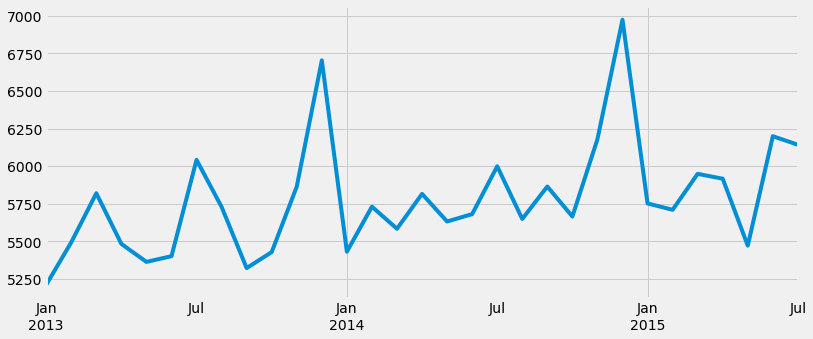

In [37]:
#visualization

merge_4_mon.plot(figsize=(12, 5))
plt.show()

In [38]:
#optimalize parameters

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [39]:
#testing data - find lowest AIC for combination
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(merge_4_mon,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:261.44641015417045
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:102.54941909448114
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:569.0222680797167
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:243.99954579809196
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:258.56548429216605
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:102.20029589006181
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:262.42130213651257
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:92.83987032648699
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:417.15681917535994
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:220.78414481479786
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:253.5898360890275
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:88.91538874662702
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:460.75151713493176
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:257.2022799232159
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:248.98060292760442
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:90.3570154942767
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:433.62981946053833
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:243.99080085352543

In [40]:
#AIC lowest:ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:75.05772566403189
mod = sm.tsa.statespace.SARIMAX(merge_4_mon, trend='n', order=(1,1,0), seasonal_order=(1,1,0,12))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -127.767
Date:                            Tue, 27 Nov 2018   AIC                            261.534
Time:                                    21:58:38   BIC                            265.836
Sample:                                01-01-2013   HQIC                           262.936
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4747      0.241     -1.967      0.049      -0.948      -0.002
ar.S.L12      -0.2543      0.510   

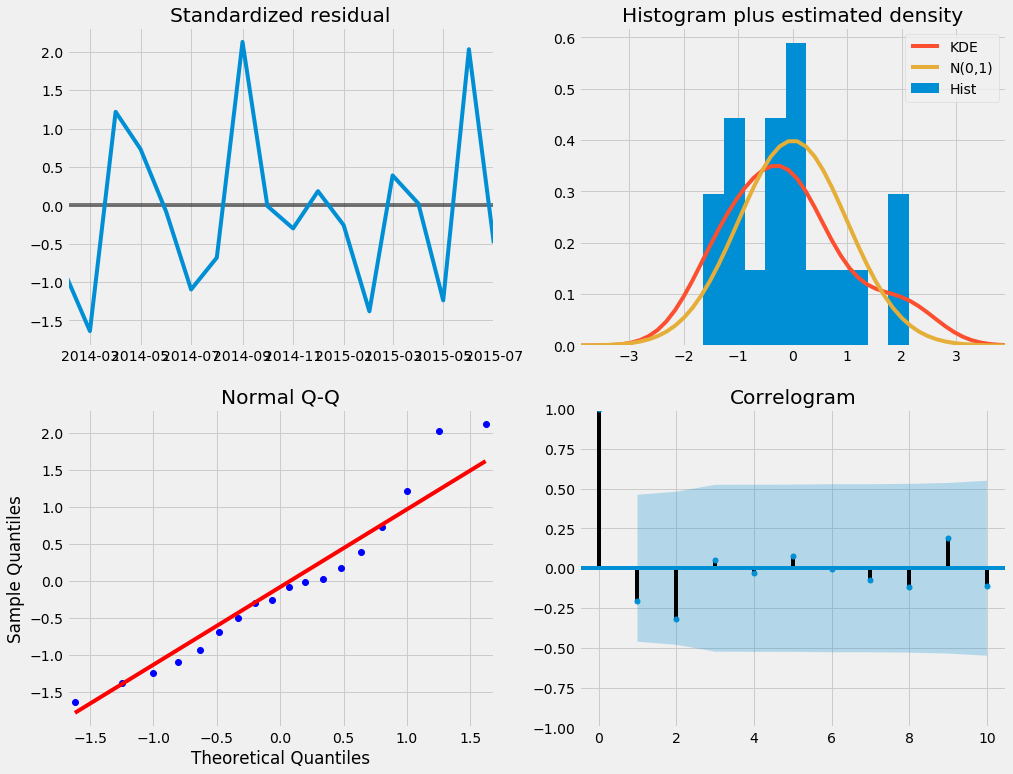

In [41]:
#visualization
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [42]:
#forcast
arima_pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = arima_pred.conf_int()

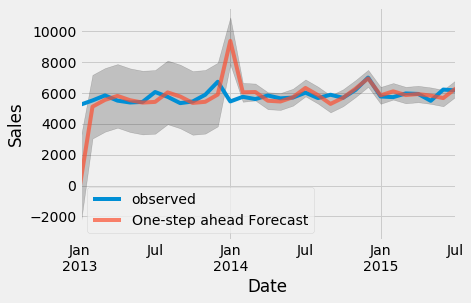

In [43]:
ax = merge_4_mon['2013':].plot(label='observed')
arima_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [44]:
#calculate output

y_forecasted = arima_pred.predicted_mean
y_truth = merge_4_mon['2013-01-01':]

# Compute the mean square error
rmspe("ARIMA",y_truth,y_forecasted)

'RMSPE for ARIMA is 0.22840263814839037'

In [45]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

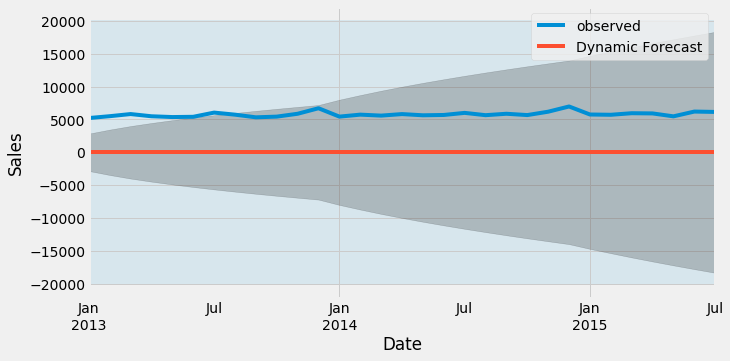

In [46]:
ax = merge_4_mon['2013':].plot(label='observed', figsize=(10, 5))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2013-01-01'), merge_4_mon.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [47]:
#calculate output

dynamic_y_forecasted = pred_dynamic.predicted_mean
y_truth = merge_4_mon['2013-01-01':]

# Compute the mean square error
rmspe("Seasonal ARIMA",y_truth,dynamic_y_forecasted)

'RMSPE for Seasonal ARIMA is 1.0'

In [48]:
#get future values

# Get forecast 50 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

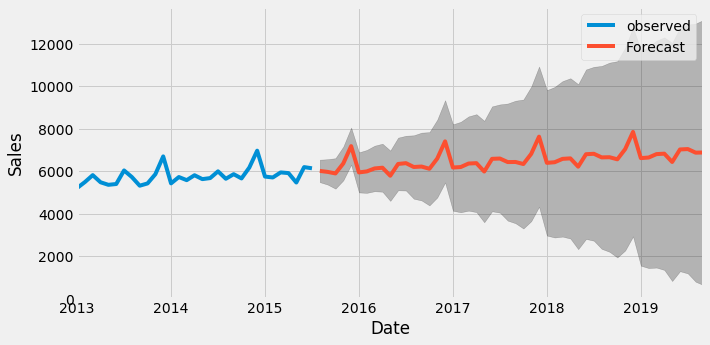

In [49]:
ax = merge_4_mon.plot(label='observed', figsize=(10, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### XGBRegressor

In [63]:
from xgboost import XGBRegressor

xgbr_regressor = XGBRegressor(n_estimators=500 , nthread=-1, max_depth=2, learning_rate = 0.01, silent = True, \
                              subsample = 0.9, colsample_bytree = 0.7)
xgbr_regressor.fit(nor_x_train, data_y_train)

y_hat = xgbr_regressor.predict(nor_x_test)
rmspe("XGBRegressor Tree",data_y_test, y_hat)

'RMSPE for XGBRegressor Tree is inf'

#### Result

Below are the results of four models: 

1. RMSPE for Decision Tree is 0.27196669110954486
2. RMSPE for Lasso is inf
3. RMSPE for AdaBoostRegressor Tree is 0.24005460287793953
4. RMSPE for Seasonal ARIMA is 1.0
5. RMSPE for XGBRegressor Tree is inf

Based on the result, AdaBoostRegressor has the best performance among them. 

In [50]:
print (nor_x_test.info())
test_feature_name = ['Id','Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', \
                'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', \
                'StateHoliday_0', 'StateHoliday_a', \
                'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', \
                'Assortment_a', 'Assortment_b', 'Assortment_c', 
                'Year', 'Month', 'Day', 'Week']

print (test_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203442 entries, 0 to 203441
Data columns (total 23 columns):
Store                        203442 non-null float64
DayOfWeek                    203442 non-null float64
Customers                    203442 non-null float64
Open                         203442 non-null float64
Promo                        203442 non-null float64
SchoolHoliday                203442 non-null float64
CompetitionDistance          203442 non-null float64
CompetitionOpenSinceMonth    203442 non-null float64
CompetitionOpenSinceYear     203442 non-null float64
Promo2                       203442 non-null float64
StateHoliday_0               203442 non-null float64
StateHoliday_a               203442 non-null float64
StoreType_a                  203442 non-null float64
StoreType_b                  203442 non-null float64
StoreType_c                  203442 non-null float64
StoreType_d                  203442 non-null float64
Assortment_a                 203442 non-n

In [55]:
adaboost_tree_predictive = adaboost_tree.predict(np.array(test_3[test_feature_name]))

In [56]:
result=pd.DataFrame({"Id": test_3["Id"], "Sales": adaboost_tree_predictive})

result.to_csv("ababoost_sample.csv", index = False)